In [1]:
!pip install tabula-py -q
!pip install pdfplumber -q

In [3]:
import tabula
import pdfplumber
import re
import os
from collections import namedtuple
import pandas as pd

# Extracting TOC (Table of Contents)

**We will extract the TOC data and use the data from TOC to dynamically find the page number that contains the required information**

**Example:**


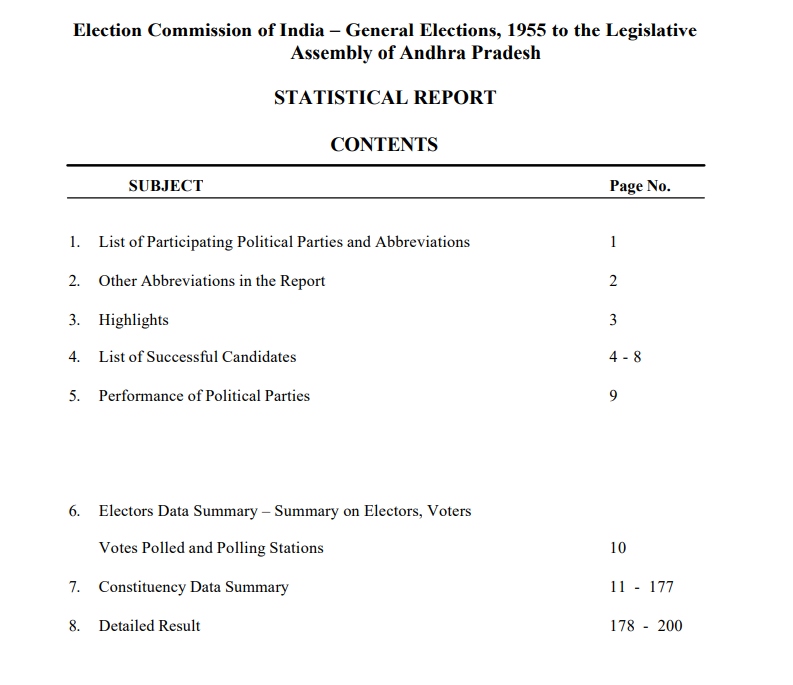

In [4]:
# find the Table of Contents and put in a list "TOC"

def extract_TOC(pdf):
    
    toc_line = namedtuple('toc_line', 'sno name pages')
    
#     toc_re = re.compile(r'(\d).[ ]*([a-zA-Z ]*)([0-9 -]*)')
#     toc_re = re.compile(r'(\d).[ ]*([a-zA-Z ]*)([0-9 -–]*)')
    toc_re = re.compile(r'(\d{1,2}) ?.[ ]*([a-zA-Z ]*)([0-9 -–]*)')

    toc= []
    
    toc_page_number = 1
    
    for i in range(5):
        page = pdf.pages[i]
        text = page.extract_text()
        lines = text.split("\n")
        

        for line in lines:
            if line.find("CONTENTS")>=0:
                toc_page_number = i
#                 print(*lines,sep="\n")
                for line_1 in lines:
                    line_1 = toc_re.search(line_1)
                    if line_1:
                        sno = line_1.group(1).strip()
                        name = line_1.group(2).strip()
                        pages = line_1.group(3).strip()
                        toc.append(toc_line(sno, name, pages))
                break

        else:
            continue

        break
    return toc,toc_page_number

 # Extracting information about Political Parties
**We will find out info about "Political Parties" pages from extraced TOC and then extract "Political Parties" data from those pages using Regex.**

**Example:**

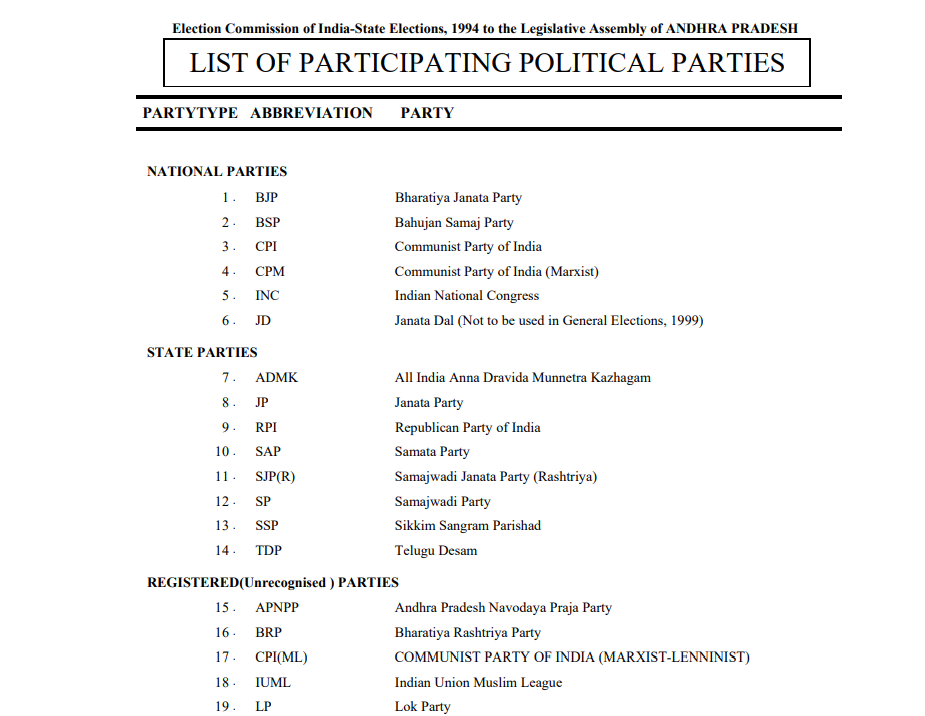

In [5]:
# Populating a list with all the input files
input_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        input_list.append(os.path.join(dirname, filename))

In [6]:

pol_pty_df_final = pd.DataFrame(columns=['sno','abbreviation','full_name','year'])        
        
## limiting the input files to 1 just for TESTING        
# for input_file in input_list[:1]:

for input_file in input_list:
    
    year = input_file.split("/")[-1].split(".")[0]        
#     print ("--------------------------------",year)
    pdf = pdfplumber.open(input_file)    
    # print(len(pdf.pages))
   
    
######################################################################
### EXTRACTION OF TOC 
######################################################################
 
    toc = []
    toc,toc_page_number = extract_TOC(pdf)

    #JUST PRINTING
#     print(*toc, sep = "\n")



######################################################################
### EXTRACTION OF POLITICAL PARTIES DETAILS 
######################################################################

    
    for toc_line in toc:
        if toc_line.name.lower().find("List of Participating".lower()) >= 0:
            page_no_extract_re = r'(\d+)\b'
            match = re.findall(page_no_extract_re, toc_line.pages)
            break
    
    #To change the datatype from str to int of the matches
    match = list(map(int, match))
    if len(match) == 1:
        political_pg_len = 1
    else:
        political_pg_len = match[1]- match[0] + 1
    
    
    political_party_page_list = pdfplumber.open(input_file).pages[ (toc_page_number+1) : (toc_page_number+1+political_pg_len) ]
    
    pol_pty_list = []
    pol_pty_line = namedtuple('pol_pty_line', 'sno abbreviation full_name year')
    
    for political_party_page in political_party_page_list:
        text = political_party_page.extract_text()
        lines = text.split("\n")
#         print(*lines, sep='\n')
        
        for line in lines:
            political_pty_re = r"^(\d{1,3})[. ]*([a-zA-Z()]+) ([a-zA-Z() '&,0-9./-]+)"
            pol_pty_match = re.match(political_pty_re,line)
            if pol_pty_match:
                sno = pol_pty_match.group(1).strip()
                abbreviation = pol_pty_match.group(2).strip()
                full_name = pol_pty_match.group(3).strip()
                pol_pty_list.append(pol_pty_line(sno, abbreviation, full_name, year))
    
    #print(*pol_pty_list, sep = "\n")
    ppty_df_single = pd.DataFrame(pol_pty_list)
    pol_pty_df_final = pd.concat([pol_pty_df_final, ppty_df_single])

pol_pty_df_final ## this dataframe contains the data for Political parties

,sno,abbreviation,full_name,year
0,1,BJS,ALL INDIA BHARTIYA JAN SANGH,1955
1,2,CPI,COMMUNIST PARTY OF INDIA,1955
2,3,INC,INDIAN NATIONAL CONGRESS,1955
3,4,PSP,PRAJA SOCIALIST PARTY,1955
4,5,PP,PRAJA PARTY,1955
...,...,...,...,...
16,17,MGS,MAHATAMA GANDHI SAMAJAM,1989
17,18,MIM,ALL INDIA MAJLIS-E ITHEHAD-UL MUSLIMEEN,1989
18,19,RPI,REPUBLICAN PARTY OF INDIA,1989
19,20,RPK,REPUBLICAN PARTY OF INDIA (KHOBRAGADE),1989


# Extracting Yearly Summary Data
**Using the data from Highlights page to capture the yearly summary data**

**Example:**

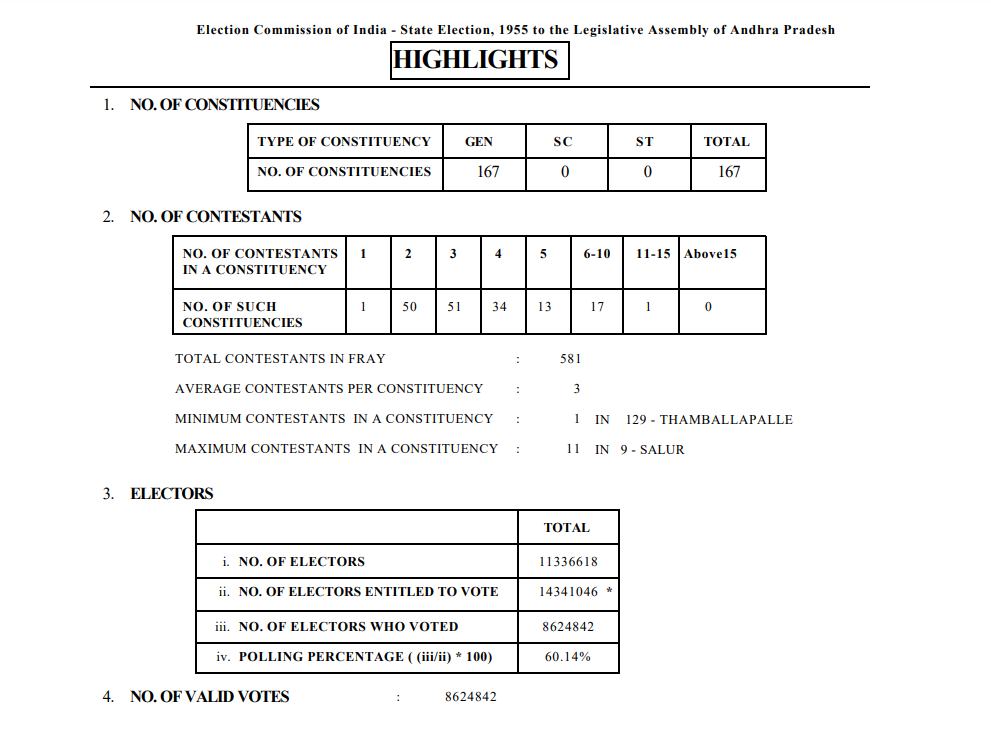

In [7]:
## Quick testing problematic files
# input_list = ["/kaggle/input/ap-assembly-election-details/2004.pdf","/kaggle/input/ap-assembly-election-details/2014.pdf","/kaggle/input/ap-assembly-election-details/1999.pdf"]

yearly_hlght_df_final = pd.DataFrame(columns=['year','no_of_constituencies','no_of_electors','no_of_electors_voted','no_of_valid_votes'])        

# for input_file in input_list[:1]:
for input_file in input_list:
    
    
    year = int(input_file.split("/")[-1].split(".")[0])        
#     print ("--------------------------------",year)
    pdf = pdfplumber.open(input_file)    
    # print(len(pdf.pages))
   
    
######################################################################
### EXTRACTION OF TOC 
######################################################################
 
    toc = []
    toc,toc_page_number = extract_TOC(pdf)

    #JUST PRINTING
#     print(*toc, sep = "\n")



# ######################################################################
# ### EXTRACTION OF Yearly Summary Data
# ######################################################################

    
    for toc_line in toc:
        if toc_line.name.lower().find("Highlights".lower()) >= 0:
            page_no_extract_re = r'(\d+)\b'
            match = re.findall(page_no_extract_re, toc_line.pages)
            break
    
    #To change the datatype from str to int of the matches
    match = list(map(int, match))
#     if len(match) == 1:
#         hlght_pg_len = 1
#     else:
#         hlght_pg_len = match[1]- match[0] + 1
    
    if int(year) == 2014:  #-------------2014's TOC is different from all the other PDFs
        hlght_pg_no = match[0]-1
    elif int(year) == 1999 or int(year) == 2004:
        hlght_pg_no = match[0]+2
    else:
        hlght_pg_no = match[0]+1
    
#     print (hlght_pg_no)
    
    hlght_pg = pdfplumber.open(input_file).pages[ hlght_pg_no ]
    
    yearly_hlght_list = []
    yearly_hlght_line = namedtuple('yearly_hlght_line', 'year no_of_constituencies no_of_electors no_of_electors_voted no_of_valid_votes')
    
    text = hlght_pg.extract_text()
    lines = text.split("\n")
#     print(*lines, sep='\n')
    
    no_of_constituencies_re = r"^NO\.{0,1} OF CONSTITUENCIES.*\b(\d{2,3})"
    no_of_electors_re = r"^i\. NO. OF ELECTORS.*\b(\d{4,9})" #for 2014, hardcode the value as PDF is inconsistent
    no_of_electors_voted_re = r".*NO. OF ELECTORS WHO.*\b(\d{4,9})" #for 2014 and 2004 hardcode the value as PDF is inconsistent
    no_of_valid_votes_re = r".*NO. OF VALID .*?\b(\d{4,9})" #for 2014, hardcode the value as PDF is inconsistent
    
    for line in lines:
        
        no_of_constituencies_re_match = re.match(no_of_constituencies_re,line)
        if no_of_constituencies_re_match:
            no_of_constituencies = no_of_constituencies_re_match.group(1)
            
            
        no_of_electors_re_match = re.match(no_of_electors_re,line)
        if no_of_electors_re_match:
            no_of_electors = no_of_electors_re_match.group(1)
        if year == 2014: no_of_electors =64934138
            
        
        no_of_electors_voted_re_match = re.match(no_of_electors_voted_re,line)
        if no_of_electors_voted_re_match:
            no_of_electors_voted = no_of_electors_voted_re_match.group(1)
        if year == 2014: no_of_electors_voted =48177984
        if year == 2004: no_of_electors_voted =35780385

        
        no_of_valid_votes_re_match = re.match(no_of_valid_votes_re,line)
        if no_of_valid_votes_re_match:
            no_of_valid_votes = no_of_valid_votes_re_match.group(1)
        if year == 2014: no_of_valid_votes =48092120
        
        
        
    yearly_hlght_list.append(yearly_hlght_line(year, no_of_constituencies, no_of_electors, no_of_electors_voted,no_of_valid_votes ))
    
#     print(*yearly_hlght_list, sep = "\n")
    yearly_hlght_df_single = pd.DataFrame(yearly_hlght_list)
    yearly_hlght_df_final = pd.concat([yearly_hlght_df_final, yearly_hlght_df_single])
    
yearly_hlght_df_final.sort_values(by=['year'])

,year,no_of_constituencies,no_of_electors,no_of_electors_voted,no_of_valid_votes
0,1955,167,11336618,8624842,8624842
0,1957,85,5561345,3603585,3603585
0,1962,300,19007856,12165283,38734159
0,1967,287,20934068,14476108,51084842
0,1972,287,24607903,14693030,14292623
0,1978,294,28386334,20698706,20150093
0,1983,294,31846694,21560642,21117111
0,1985,294,34587372,23370750,22995337
0,1989,294,42448805,29899530,28750951
0,1994,294,44725091,31763466,31136834


In [8]:
# Populating a list with all the input files
input_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        input_list.append(os.path.join(dirname, filename))

# Extracting Constituency data

**Example:**

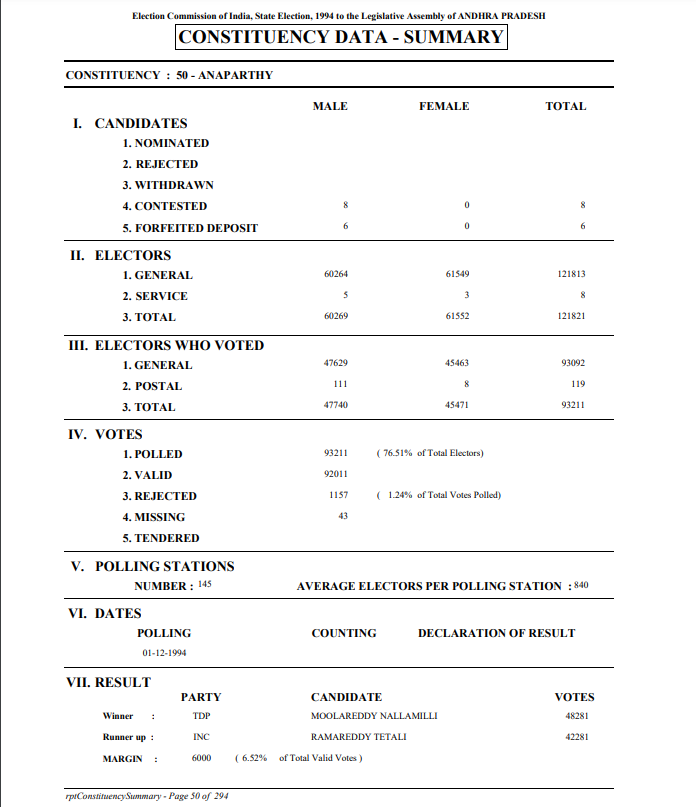

In [9]:
## Quick testing problematic files
# input_list = ["/kaggle/input/ap-assembly-election-details/2004.pdf","/kaggle/input/ap-assembly-election-details/2014.pdf","/kaggle/input/ap-assembly-election-details/1999.pdf"]
# input_list = ["/kaggle/input/ap-assembly-election-details/2014.pdf"] #,"/kaggle/input/ap-assembly-election-details/1994.pdf"]


const_dtl_df_final = pd.DataFrame(columns=['year','const_number','const_name','no_of_electors','no_of_voters'])        
# constituency_summary (year, const_number, const_name, no_of_electors, no_of_voters)


# for input_file in input_list[:1]:
for input_file in input_list:
    
    
    year = int(input_file.split("/")[-1].split(".")[0])        
#     print ("----------------------------------------------------------------------------------------",year)
    pdf = pdfplumber.open(input_file)    
    # print(len(pdf.pages))
   
    
######################################################################
### EXTRACTION OF TOC 
######################################################################
 
    toc = []
    toc,toc_page_number = extract_TOC(pdf)

    # PRINTING for debugging
#     print(*toc, sep = "\n")



# ######################################################################
# ### EXTRACTION OF Constituency Data
# ######################################################################

    
    for toc_line in toc:
        if toc_line.name.lower().find("Constituency".lower()) >= 0:
            page_no_extract_re = r'(\d+)\b'
            match = re.findall(page_no_extract_re, toc_line.pages)
            break
    
#     #To change the datatype from str to int of the matches
    match = list(map(int, match))
    
    if len(match) == 2:
        const_dtl_len = match[1]- match[0] + 1
#         print(match[0],match[1],const_dtl_len)
        
    if int(year) == 2014:  #-------------2014's TOC is different from all the other PDFs
        const_dtl_no = match[0]-1
    elif int(year) == 1999 or int(year) == 2004 or int(year) == 1955 or int(year) == 1957 or int(year) == 1972 or int(year) == 1967 or int(year) == 1962:
        const_dtl_no = match[0]+2
    elif int(year) == 1999 or int(year) == 2004:
        const_dtl_no = match[0]+2
    else:
        const_dtl_no = match[0]+1
    
#     print(const_dtl_no,const_dtl_no + const_dtl_len)
    const_dtl_pg_list = pdfplumber.open(input_file).pages[ const_dtl_no : const_dtl_no + const_dtl_len ]
#     const_dtl_pg_list = pdfplumber.open(input_file).pages[ 141:142 ]

    
    const_dtl_list = []
    const_dtl_line = namedtuple('const_dtl_line', 'year const_number const_name no_of_electors no_of_voters')

    for const_dtl_page in const_dtl_pg_list:
        text = const_dtl_page.extract_text()
        lines = text.split("\n")
        
#         print("------------")
#         print(*lines, sep='\n')
        
        const_name_num_re = r'(?:CONS)?TITUENCY\s*:\s*(\d+)\s*-\s*([\w\s\(\).\-]+?)(?=\sNUMBER OF SEATS|$)'
        electors_voters_count_re = r'TOTAL(?!.*VOTES).*?\s(\d+)$'
        
        elector_voters_count_list = []

        for line in lines:
            const_name_num_re_match = re.search(const_name_num_re,line)
            if const_name_num_re_match:
                const_num = int(const_name_num_re_match.group(1).strip())
                const_name = const_name_num_re_match.group(2).strip()
#                 print (const_num,"|",const_name)
            electors_voters_count_re_Match = re.search(electors_voters_count_re,line)
            if electors_voters_count_re_Match:
                count = int(electors_voters_count_re_Match.group(1).strip())
                elector_voters_count_list.append(count)
            

        if len(elector_voters_count_list) == 1:
            elector_voters_count_list.append(-1)
#         print(const_num,const_name, sep = ' # ')
#         print(*elector_voters_count_list, sep = '|')

    
        if len(elector_voters_count_list) > 0:
            const_dtl_list.append(const_dtl_line(year, const_num, const_name, elector_voters_count_list[0],elector_voters_count_list[1] ))
#             print(year, const_num, const_name, elector_voters_count_list[0],elector_voters_count_list[1], sep=' # ')
# #         const_dtl_line = namedtuple('const_dtl_line', 'year const_number const_name no_of_electors no_of_voters')

    if year == 2014:
        const_dtl_list.append(const_dtl_line(2014, 288, "Satyavedu (SC)", 193718,161036 ))
    
#     print(len(const_dtl_list))
    const_dtl_df_single = pd.DataFrame(const_dtl_list)
    const_dtl_df_final = pd.concat([const_dtl_df_final, const_dtl_df_single])

In [10]:
const_dtl_df_final

,year,const_number,const_name,no_of_electors,no_of_voters
0,1955,1,ICHAPURAM,54716,32165
1,1955,2,SOMPETA,61481,31631
2,1955,3,BRAHMANATARALA,58375,29313
3,1955,4,TEKKALI,62108,33707
4,1955,5,NARASANNAPETA,53940,24250
...,...,...,...,...,...
289,1989,290,RAMANAPET,147540,103765
290,1989,291,ALAIR (SC),140629,99990
291,1989,292,BHONGIR,156193,115853
292,1989,293,MUNGODE,144628,100989


# Extracting the Detailed Results data

**Three examples shown below:**

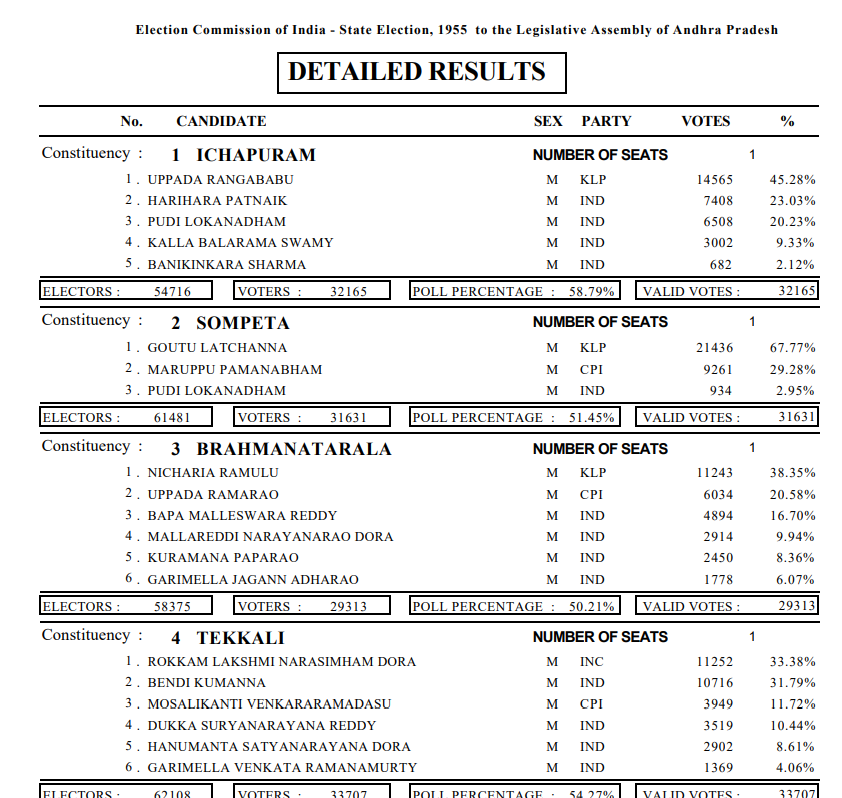
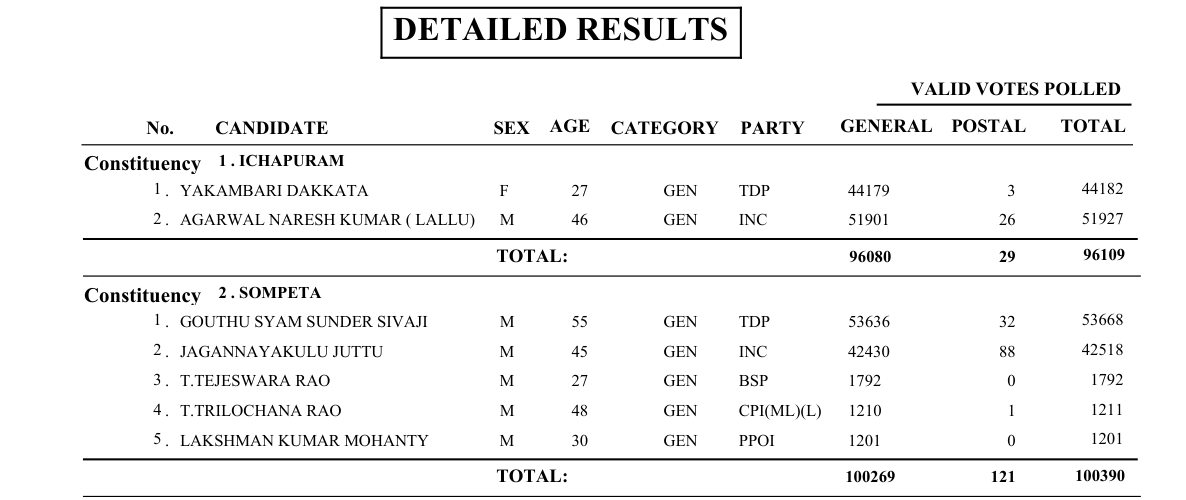
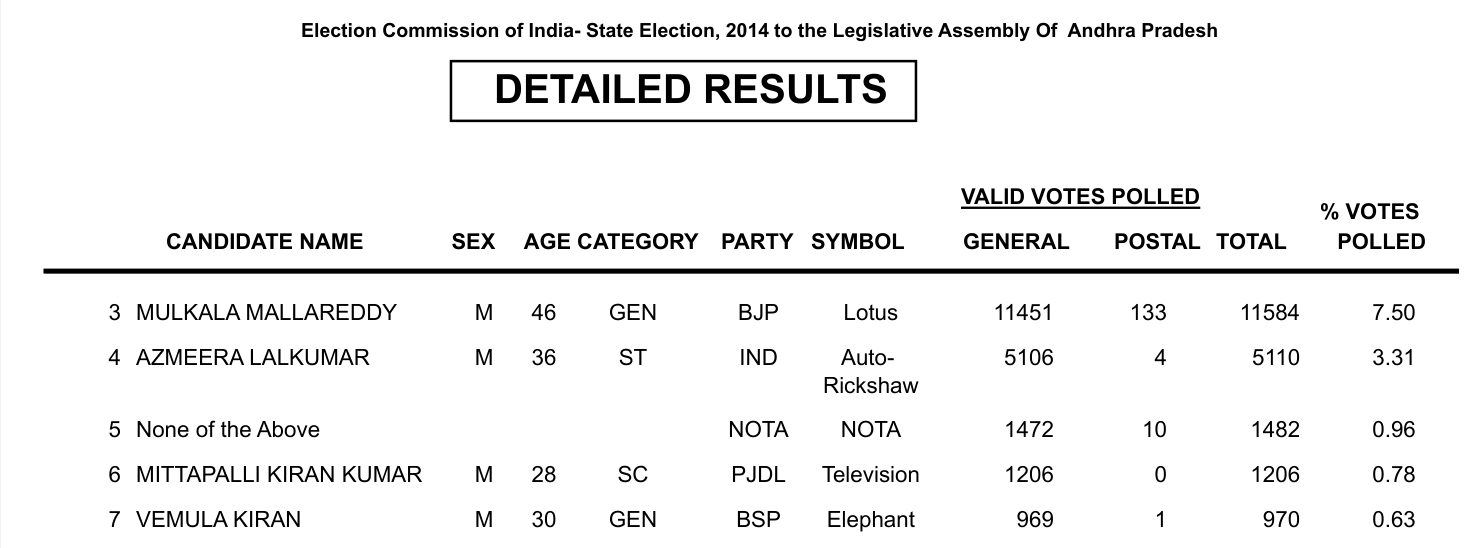

In [11]:
# Populating a list with all the input files
input_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        input_list.append(os.path.join(dirname, filename))

In [12]:
## Quick testing problematic files
# input_list = ["/kaggle/input/ap-assembly-election-details/2004.pdf","/kaggle/input/ap-assembly-election-details/2014.pdf","/kaggle/input/ap-assembly-election-details/1955.pdf"]
# input_list = ["/kaggle/input/ap-assembly-election-details/2014.pdf"] #,"/kaggle/input/ap-assembly-election-details/1994.pdf"]


results_df_final = pd.DataFrame(columns=['position','name','gender','age','party','votes','year','constituency_number', 'constituency_name'])        
# results (position, name, gender, age, party, votes, year, constituency_number, constituency_name)


# for input_file in input_list[:1]:
for input_file in input_list:
    
    
    year = int(input_file.split("/")[-1].split(".")[0])        
#     print ("---------------------------------------------------",year)
    pdf = pdfplumber.open(input_file)    
    # print(len(pdf.pages))
   
    
######################################################################
### EXTRACTION OF TOC 
######################################################################
 
    toc = []
    toc,toc_page_number = extract_TOC(pdf)

    # PRINTING for debugging
#     print(*toc, sep = "\n")



# # ######################################################################
# # ### EXTRACTION OF Results Data
# # ######################################################################

    
    for toc_line in toc:
        if toc_line.name.lower().find("Detail".lower()) >= 0:
            page_no_extract_re = r'(\d+)\b'
            match = re.findall(page_no_extract_re, toc_line.pages)
            break
    
# #     #To change the datatype from str to int of the matches
    match = list(map(int, match))
    
    if len(match) == 2:
        results_len = match[1]- match[0] + 1
#         print(match[0],match[1],const_dtl_len)
        
    if int(year) == 2014:  #-------------2014's TOC is different from all the other PDFs
        results_no = match[0]-1
    elif int(year) == 1999 or int(year) == 2004 or int(year) == 1955 or int(year) == 1957 or int(year) == 1972 or int(year) == 1967 or int(year) == 1962:
        results_no = match[0]+2
    elif int(year) == 1999 or int(year) == 2004:
        results_no = match[0]+2
    else:
        results_no = match[0]+1
    
    
    t1_results_re = r'^(\d{1,2})\.?\s*([a-zA-Z.,_\s\(\)-]*)\s([A-Z]{1})\b\s+([a-zA-Z()]{2,})\s(\d+)'
    t2_results_re = r'^(\d{1,2})\.?\s*([a-zA-Z.,_\s\(\)-]*)\s([A-Z]{1})\s+(\d{2})\s+(?:[A-Z]{2,3})\s+([a-zA-Z()]{2,})\s+(?:\d{1,})\s+(?:\d{1,})\s+(\d{1,})'
    t3_results_re = r'^(\d{1,2})\.?\s*([a-zA-Z.,_\s\(\)-]*)\s([A-Z]{1})\s+(\d{2})\s+(?:[A-Z]{2,3})\s+([a-zA-Z()]{2,})\s+(?:[a-zA-Z\s&-]+)\s+(?:\d{1,})\s+(?:\d{1,})\s+(\d{1,})'
    t4_results_re = r'^(\d{1,2})\.?\s*.*None.*?(?:\d{1,}\s)+(\d{1,})(?=\s)'
    const_re = r'Constituency\s*?(?::\s)?(\d{1,3})\s*\.?\s+([\w\s\(\).\-]+?)(?=\sNUMBER|$|\sTOTAL)'
    
    
#     print(const_dtl_no,const_dtl_no + const_dtl_len)
    results_pg_list = pdfplumber.open(input_file).pages[ results_no  : results_no + results_len ] # : const_dtl_no + const_dtl_len ]
#     const_dtl_pg_list = pdfplumber.open(input_file).pages[ 141:142 ]

    
    results_list = []
    results_line = namedtuple('results_line', 'position name gender age party votes year constituency_number constituency_name')
    # results (position, name, gender, age, party, votes, year, constituency_number, constituency_name)



    for results_page in results_pg_list:
        text = results_page.extract_text()
        lines = text.split("\n")
        
#         print("--------------------------")
#         print(*lines, sep='\n')
        
        results_list = []
        
#         constituency_number = 0
#         constituency_name = 'TEST-HOPE'

        for line in lines:
#             print (line)
            if re.search(const_re,line):
#                 print("################entered const")
                const_re_match = re.search(const_re,line)
                constituency_number = int(const_re_match.group(1).strip())
                constituency_name = const_re_match.group(2).strip()
            
            if re.search(t1_results_re,line):
#                 print("################entered t1")
                results_re_match = re.search(t1_results_re,line)
                
                position = int(results_re_match.group(1).strip())
                name = results_re_match.group(2).strip()
                gender = results_re_match.group(3).strip()
                age = -1
                party = results_re_match.group(4).strip()
                votes = results_re_match.group(5).strip()
                
                results_list.append(results_line(position, name, gender, age,party,votes,year,constituency_number,constituency_name ))
                
            elif re.search(t2_results_re,line):
#                 print("################entered t2")
                results_re_match = re.search(t2_results_re,line)
                
                position = int(results_re_match.group(1).strip())
                name = results_re_match.group(2).strip()
                gender = results_re_match.group(3).strip()
                age = results_re_match.group(4).strip()
                party = results_re_match.group(5).strip()
                votes = results_re_match.group(6).strip()
                
                results_list.append(results_line(position, name, gender, age,party,votes,year,constituency_number,constituency_name ))
                
            elif re.search(t3_results_re,line):
#                 print("################entered t3")
                results_re_match = re.search(t3_results_re,line)
                
                position = int(results_re_match.group(1).strip())
                name = results_re_match.group(2).strip()
                gender = results_re_match.group(3).strip()
                age = results_re_match.group(4).strip()
                party = results_re_match.group(5).strip()
                votes = results_re_match.group(6).strip()
                
                results_list.append(results_line(position, name, gender, age,party,votes,year,constituency_number,constituency_name ))
                
            elif re.search(t4_results_re,line):
#                 print("################entered t4 nota ")
                results_re_match = re.search(t4_results_re,line)

                position = int(results_re_match.group(1).strip())
                name = "None of the Above"
                gender = "Q"
                age = -1
                party = "NOTA"
                votes = int(results_re_match.group(2).strip())

                results_list.append(results_line(position, name, gender, age,party,votes,year,constituency_number,constituency_name ))

        
#         print (*results_list,sep="\n")        
            

#         print("%%%%%%%%%%%%%%%%%%<<<<<<<<<<<<",len(results_list),len(results_df_final))
        results_df_single = pd.DataFrame(results_list)
        results_df_final = pd.concat([results_df_final, results_df_single])

In [14]:
len(results_df_final)
results_df_final

,position,name,gender,age,party,votes,year,constituency_number,constituency_name
0,1,UPPADA RANGABABU,M,-1,KLP,14565,1955,1,ICHAPURAM
1,2,HARIHARA PATNAIK,M,-1,IND,7408,1955,1,ICHAPURAM
2,3,PUDI LOKANADHAM,M,-1,IND,6508,1955,1,ICHAPURAM
3,4,KALLA BALARAMA SWAMY,M,-1,IND,3002,1955,1,ICHAPURAM
4,5,BANIKINKARA SHARMA,M,-1,IND,682,1955,1,ICHAPURAM
...,...,...,...,...,...,...,...,...,...
0,1,BADDU CHOWHAN MOOD,M,-1,CPI,49414,1989,294,DEVERKONDA (ST)
1,2,D. BAGYA NAIK,M,-1,INC,44214,1989,294,DEVERKONDA (ST)
2,3,BADDYA NAIAK N.,M,-1,IND,1459,1989,294,DEVERKONDA (ST)
3,4,MUTHAIAH KURAKULA,M,-1,IND,1199,1989,294,DEVERKONDA (ST)


# Exporting the data from DataFrames to CSV files

In [16]:
results_df_final.to_csv('/kaggle/working/results_df_final.csv', index=False)
const_dtl_df_final.to_csv('/kaggle/working/const_dtl_df_final.csv', index=False)
yearly_hlght_df_final.to_csv('/kaggle/working/yearly_hlght_df_final.csv', index=False)
pol_pty_df_final.to_csv('/kaggle/working/pol_pty_df_final.csv', index=False)